In [4]:
from thirdi_utils import load_image_list
import os
import turbojpeg
import numpy as np
import warnings
import pickle
from thirdi_utils import parallel

def get_brightness(fn):
    tj = turbojpeg.TurboJPEG()
    warnings.filterwarnings("error")
    try:
        with open(fn, 'rb') as f:
            img = tj.decode(f.read())
        mean = np.median(img)
        return mean
    except:
        return None

def build_brightness_list():
    image_list = load_image_list()
    filenames = [e[1] for e in image_list]
    brightness_list = parallel(get_brightness, filenames)
    return brightness_list

def load_brightness_list():
    cache_fn = "brightness_list.pkl"
    if os.path.exists(cache_fn):
        with open(cache_fn, "rb") as f:
            return pickle.load(f)
    else:
        brightness_list = build_brightness_list()
        with open(cache_fn, "wb") as f:
            pickle.dump(brightness_list, f)
        return brightness_list
    
brightness_list = load_brightness_list()

100%|██████████| 432925/432925 [03:24<00:00, 2113.56it/s]


In [3]:
image_list = load_image_list()
for fn, brightness in zip(image_list, brightness_list):
    print(f"{fn}: {brightness}")
    break

(datetime.datetime(2010, 12, 12, 12, 50, 37), 'images/12-12-2010/12-50-37.jpg'): 15.688551945832799


In [32]:
from collections import defaultdict

def build_time_of_day():
    threshold = 5
    image_list = load_image_list()
    brightness_list = load_brightness_list()
    by_time_of_day = defaultdict(list)
    for pair, brightness in zip(image_list, brightness_list):
        if brightness is None:
            # almost 60 images are "broken"
            continue
        if brightness < threshold:
            continue
        timestamp, fn = pair
        time_of_day = f"{timestamp.hour:02d}:{timestamp.minute:02d}"
        month_and_day = int(f"{timestamp.month:02d}{timestamp.day:02d}")
        by_time_of_day[time_of_day].append((month_and_day, fn))
        
    for k, v in by_time_of_day.items():
        by_time_of_day[k] = sorted(v)
        
    return by_time_of_day

by_time_of_day = build_time_of_day()

In [28]:
"fewest photos", min([len(v) for v in by_time_of_day.values()]), 'of', len(by_time_of_day)

('fewest photos', 19, 'of', 1440)

In [34]:
# by_time_of_day["18:00"]

In [74]:
import datetime
from bisect import bisect_left

def get_image_path(dt):
    time_of_day = f"{dt.hour:02d}:{dt.minute:02d}"
    options = by_time_of_day[time_of_day]
    month_and_day = int(f"{dt.month:02d}{dt.day:02d}")
    idx = bisect_left(options, (month_and_day, ""))
    idx = min(idx, len(options) - 1)
    fn = options[idx][1]
    return fn

In [ ]:
with open('entire-year.txt', 'w') as f:
    for month in range(1,13):
        for day in range(1, 32):
            for hour in range(24):
                for minute in range(0, 60):
                    try:
                        dt = datetime.datetime(2020, month, day, hour, minute)
                    except ValueError:
                        continue
                    fn = get_image_path(dt)
                    f.write(f"{fn}\n")

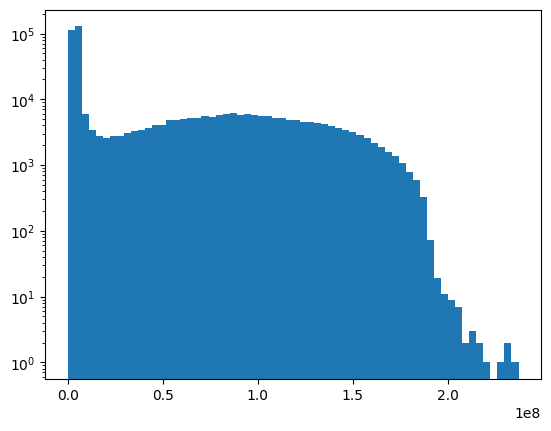

In [27]:
import matplotlib.pyplot as plt
plt.hist([e for e in brightnesses if e is not None], bins=64)
plt.yscale('log')
plt.show()

In [28]:
paired = list(zip(brightnesses, filenames))
paired = [e for e in paired if e[0] is not None]
paired.sort()

In [29]:
from utils.imutil import imshow, imread, imwrite
from utils.mosaic import make_mosaic
from bisect import bisect_left
idx = [bisect_left(paired, (i, '')) for i in np.linspace(0, paired[-1][0], 256)]
images = [imread(paired[i][1]) for i in idx]
mosaic = make_mosaic(images)

In [30]:
imwrite('mosaic.jpg', mosaic)

True